# Simulation for Optimization examples


In [153]:

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats as stats
from scipy.stats import poisson, rv_discrete, binom, rv_discrete, norm, halfnorm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Problem 1

### You operate an aircraft that flies two flights per day: an "outbound" flight from its base to a remote destination, and then and "inbound" flight back again. The aircraft can carry a mix of passengers and freight:

### If configured for all passengers, the aircraft holds 216 seats. Each freight pallet you configure the aircraft to hold takes away 24 seats, and you are considering setting up the aircraft to hold 0, 1, 2, 3, 4, 5, or 6 freight pallets. The split between seats and space for pallets must be decided once a year when the aircraft undergoes "heavy maintenance"; it cannot be changed for each flight.

### You make a profit of $50 for each passenger carried (in either direction), and demand for seats on the outbound flight is Poisson with a mean of 160, while demand for seats on the inbound flight is Poisson with a mean of 159 (independent of the outbound flight). Demand for freight carriage is independent of passenger demand and also independent between the inbound and outbound flights.(See Pallet_Table).You make a profit $275 per pallet carried (in either direction). What aircraft configuration maximizes the average profit per day?

<style>
table
{
    margin: auto;
}
</style>


|num  | outbound_pallets_prob|   inbound_pallets_prob |
|:--:|:--:|:--:|
| 0                     | 0.06                 | 0.07 |
| 1                     | 0.08                 | 0.09 |
| 2                     | 0.18                 | 0.18 |
| 3                     | 0.20                 | 0.19 |
| 4                     | 0.21                 | 0.17 |
| 5                     | 0.16                 | 0.16 |
| 6                     | 0.11                 | 0.14 |


### Set the parameters of the problem and generate the random variables


In [154]:
N = 10000
n = (0, 1, 2, 3, 4, 5, 6)  # number of pallets considered

# seats_capacity = 216
# taken_by_each_pallet = 24


mu_out = 160  # demand for seats on the outbound flight is Poisson with a mean of 160

mu_in = 159  # demand for seats on the inbound flight is Poisson with a mean of 159

# passenger_profit = 50 / seat
# pallet_profit = 275 / pallet


In [155]:
# Pallets_Table

Outbound_Pallets = pd.DataFrame([0.06, 0.08, 0.18, 0.2, 0.21, 0.16, 0.11],
                                columns=['outbound_pallets_prob'],
                                index=n)

Inbound_Pallets = pd.DataFrame([0.07, 0.09, 0.18, 0.19, 0.17, 0.16, 0.14],
                               columns=['inbound_pallets_prob'],
                               index=n)


In [156]:
Pallets_Table = pd.merge(Outbound_Pallets,
                         Inbound_Pallets,
                         left_index=True,
                         right_index=True)

Pallets_Table


,outbound_pallets_prob,inbound_pallets_prob
0,0.06,0.07
1,0.08,0.09
2,0.18,0.18
3,0.20,0.19
4,0.21,0.17
5,0.16,0.16
6,0.11,0.14


In [157]:
demand_pal_Out_rvs = rv_discrete(
    name='Pal_Out_rvs',
    values=(n, Pallets_Table['outbound_pallets_prob'])).rvs(size=N)

demand_pal_In_rvs = rv_discrete(name='Pal_In_rvs',
                                values=(n,
                                        Pallets_Table['inbound_pallets_prob'])).rvs(size=N)


In [158]:
demand_pal_Out_rvs


array([3, 6, 5, ..., 6, 3, 2])

In [159]:
demand_pal_In_rvs


array([3, 2, 2, ..., 2, 3, 2])

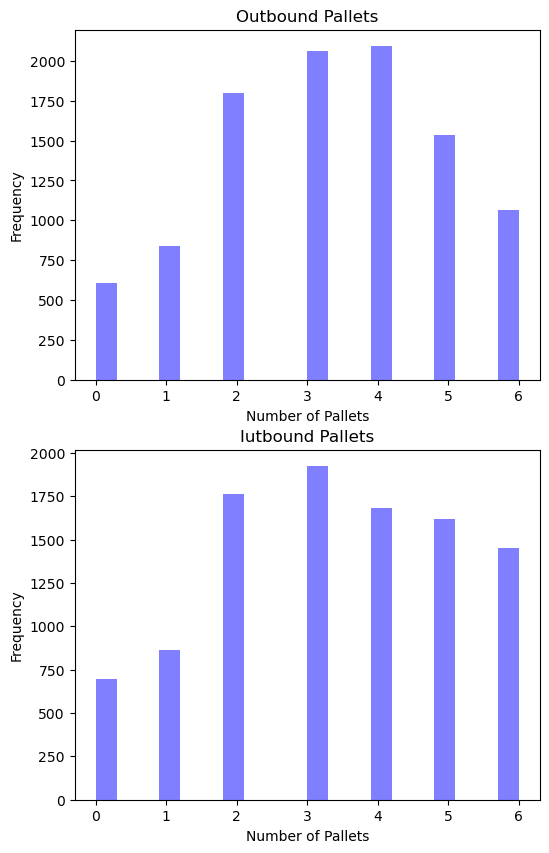

In [150]:
_, axes = plt.subplots(2, 1, figsize=(6, 10))

axes[0].hist(demand_pal_Out_rvs, bins=20, color='blue', alpha=0.5)
axes[0].set(title='Outbound Pallets',
            xlabel='Number of Pallets', ylabel='Frequency')

axes[1].hist(demand_pal_In_rvs, bins=20, color='blue', alpha=0.5)
axes[1].set(title='Iutbound Pallets',
            xlabel='Number of Pallets', ylabel='Frequency')

plt.show()


In [151]:
# Seats demand random variables

demand_seats_Out_rvs = poisson(mu_out).rvs(size=N)
demand_seats_In_rvs = poisson(mu_in).rvs(size=N)


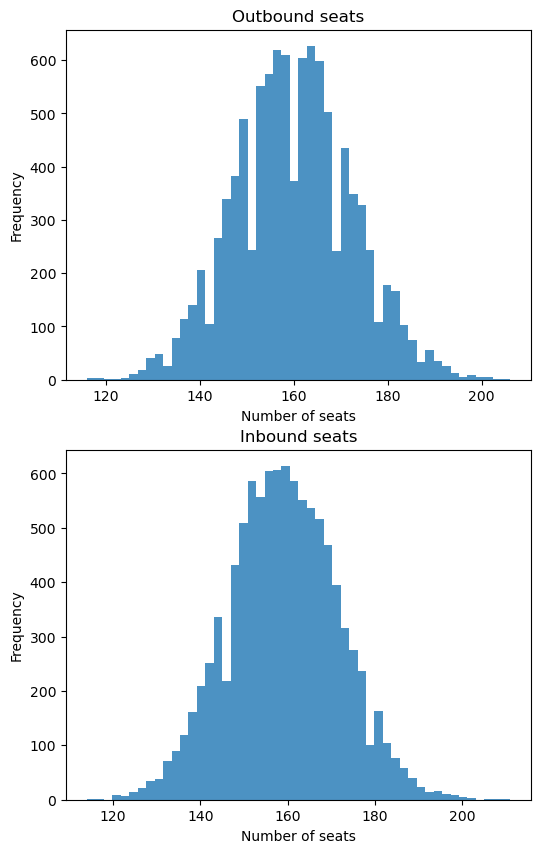

In [135]:
_, axes = plt.subplots(2, 1, figsize=(6, 10))

axes[0].hist(demand_seats_Out_rvs, bins=50, alpha=0.8)
axes[0].set(title='Outbound seats',
            xlabel='Number of seats', ylabel='Frequency')

axes[1].hist(demand_seats_In_rvs, bins=50, alpha=0.8)
axes[1].set(title='Inbound seats',
            xlabel='Number of seats', ylabel='Frequency')

plt.show()


### Considering setting up the aircraft to hold 0, 1, 2, 3, 4, 5, or 6 freight pallets


In [136]:
# When there is 0 freight pallet in the plane.
# Pallets sale = min(demand_pallets and 0),thus:

pallets_Out_sale = 0
pallets_In_sale = 0


In [137]:
# number_of_seats_In_and_Out_available = seats_capacity = 216
seats_Out_sale = np.minimum(demand_seats_Out_rvs, np.ones(N) * 216)
seats_In_sale = np.minimum(demand_seats_In_rvs, np.ones(N) * 216)


In [138]:
seats_Out_sale, seats_In_sale


(array([169., 154., 159., ..., 157., 185., 147.]),
 array([161., 154., 159., ..., 167., 173., 142.]))

In [139]:
profit_Out = seats_Out_sale * 50
profit_In = seats_In_sale * 50


In [140]:
profit_total = profit_Out + profit_In
mean_profit_0 = np.mean(profit_total)


In [141]:
print(
    f"When there is 0 freight pallet in the plane.\nthe mean of the profit is {mean_profit_0}")


When there is 0 freight pallet in the plane.
the mean of the profit is 15950.37


In [142]:
def mean_profit(i, seats_capacity=216):  # 0<= i <=9
    pallets_Out_sale = np.minimum(demand_pal_Out_rvs, np.ones(N) * i)
    pallets_In_sale = np.minimum(demand_pal_In_rvs, np.ones(N) * i)

    # number_of_seats_In_and_Out_available = seats_capacity - taken_by_each_pallet

    seats_Out_available = seats_capacity - pallets_Out_sale * 24
    seats_Out_sale = np.minimum(demand_seats_Out_rvs, seats_Out_available)

    seats_In_available = seats_capacity - pallets_In_sale * 24
    seats_In_sale = np.minimum(demand_seats_In_rvs, seats_In_available)

    profit_Out = seats_Out_sale * 50 + pallets_Out_sale * 275
    profit_In = seats_In_sale * 50 + pallets_In_sale * 275

    profit_total = profit_Out + profit_In
    return np.mean(profit_total)


In [143]:
for i in range(1, 7):
    print(
        f"When there are {i} pallets in the plane.\nthe mean of the profit is {mean_profit(i)}")


When there are 1 pallets in the plane.
the mean of the profit is 16462.0975
When there are 2 pallets in the plane.
the mean of the profit is 16770.905
When there are 3 pallets in the plane.
the mean of the profit is 16183.5175
When there are 4 pallets in the plane.
the mean of the profit is 15339.9925
When there are 5 pallets in the plane.
the mean of the profit is 14815.485
When there are 6 pallets in the plane.
the mean of the profit is 14582.57


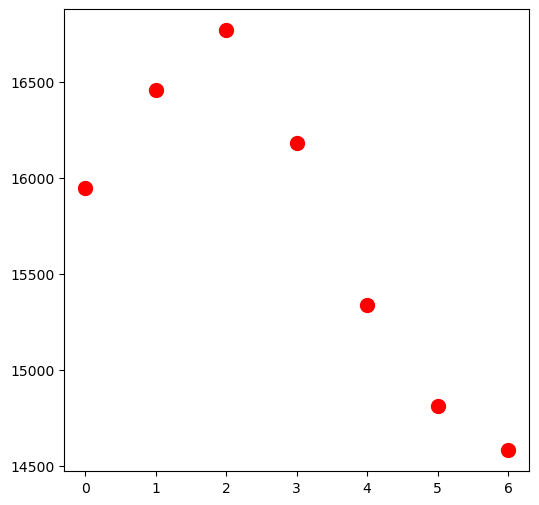

In [144]:
_, ax = plt.subplots(figsize=(6, 6))

for i in range(1, 7):
    ax.plot(i, mean_profit(i), 'ro', markersize=10)

ax.plot(0, mean_profit_0, 'ro', markersize=10)

plt.show()


## Ans:

### From the plot above we can see that when there are 2 pallets in the plane, the mean of the profit is the highest of 16770.905.


## Problem 2

### You run a newspaper stand. You cannot predict exactly how many copies of the Daily Blab newspaper you will be able to sell, but in the past, you have observed the following demand pattern:

<style>
table
{
    margin: auto;
}
</style>

|Demand|Percentage of the Time|
|:-:|:-:|
| 20 | 1% |
| 21 | 2% |
| 22 | 3% |
| 23 | 4% |
| 24 | 5% |
| 25 | 6% |
| 26 | 6% |
| 27 | 7% |
| 28 | 7% |
| 29 | 7% |
| 30 | 7% |
| 31 | 7% |
| 32 | 7% |
| 33 | 6% |
| 34 | 5% |
| 35 | 4% |
| 36 | 4% |
| 37 | 3% |
| 38 | 3% |
| 39 | 3% |
| 40 | 3% |

#### Each copy of the Daily Blab costs you $0.35 and sells for $0.45. You must place your order for the papers the night before they are sold, before you know exactly how many copies you will be able to sell. Unsold copies may be returned to the publisher at the end of the day for a credit of $0.05 each. You can buy the paper only in multiples of 5, and are considering stocking either 20, 25, 30, 35, or 40 papers per day. What is the right number of papers to order each night?


In [80]:
n = np.arange(20, 41)

percent_demand = pd.DataFrame(
    [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07,
     0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03
     ], index=n)


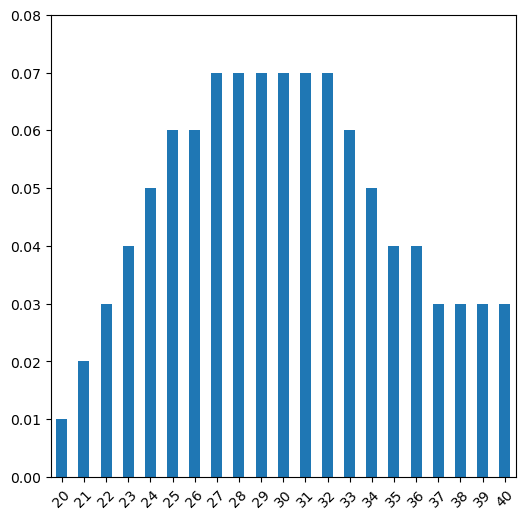

In [81]:
_, ax = plt.subplots(figsize=(6, 6))

percent_demand.plot.bar(ax=ax)

ax.set(ylim=(0, 0.08))
ax.set_xticklabels(percent_demand.index, rotation=45)

plt.legend().remove()
plt.show()


In [82]:
N = 10000


In [83]:
news_rvs = rv_discrete(name='news_rvs',
                       values=(n, percent_demand[0])).rvs(size=N)

news_20 = news_rvs[news_rvs == 20]
news_25 = news_rvs[news_rvs <= 25]
news_30 = news_rvs[news_rvs <= 30]
news_35 = news_rvs[news_rvs <= 35]
news_40 = news_rvs


In [84]:
profit_20 = news_20 * 0.45 - 20 * 0.35
profit_25 = news_25 * 0.45 - 25 * 0.35 + (25 - news_25) * 0.05
profit_30 = news_30 * 0.45 - 30 * 0.35 + (30 - news_30) * 0.05
profit_35 = news_35 * 0.45 - 35 * 0.35 + (35 - news_35) * 0.05
profit_40 = news_40 * 0.45 - 40 * 0.35


In [85]:
means = []

for profit in (profit_20, profit_25, profit_30, profit_35, profit_40):
    means.append(np.mean(profit))
    print(round(profit.mean(), 4))


2.0
1.8355
1.5234
0.9199
-0.5004


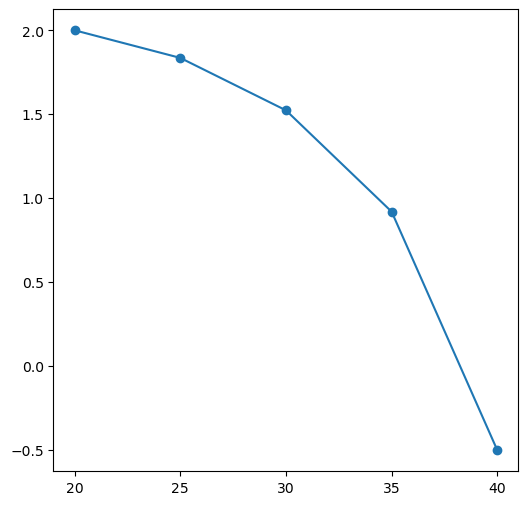

In [86]:
_, ax = plt.subplots(figsize=(6, 6))

plt.plot(means, 'o-')

ax.set_xticks(range(len(means)))
ax.set_xticklabels(['20', '25', '30', '35', '40'])

plt.show()


So, We should order 20 newspapers each night to make the mean profit by 2 dollars.


## Problem 3

You are taking reservations for an airline flight. This particular flight uses an aircraft with 50 first- class seats and 190 economy-class seats.

First-class tickets on the flight cost $600, with demand to purchase them distributed like a Poisson random variable with mean 50. Each passenger who buys a first-class ticket has a 93% chance of showing up for the flight. If a first-class passenger does not show up, he or she can return their unused ticket for a full refund. Any first class passengers who show up for the flight with tickets but are denied boarding are entitled to a full refund plus a $500 inconvenience penalty.

Economy tickets cost $300. Demand for them is Poisson distributed with a mean of 200, and is independent of the demand for first-class tickets. Each ticket holder has a 96% chance of showing up for the flight, and "no shows" are not entitled to any refund. If an economy ticket holder shows up and is denied a seat, however, they get a full refund plus a $200 penalty. If there are free seats in first class and economy is full, economy ticket holders can be seated in first class.

The airline allows itself to sell somewhat more tickets than it has seats. This is a common practice called "overbooking". The firm is considering the 18 possible polices obtained through all possible combinations of:

- Allowing overbooking of up to 0, 5, or 10 first-class seats
- Allowing overbooking of up to 0, 5, 10, 15, 20, or 25 economy seats

1. Which option gives the highest average profit?
2. What are the average numbers of first-class and economy passengers denied seating under this policy.
3. If no overbooking of first class is allowed, what is the best policy?


<style>
table
{
    margin: auto;
}
</style>

## Problem 4( Dynamic Models)

You manage the Big-Rig Service Center, which runs a thriving business performing repairs on large trucks.

The number of trucks arriving at the facility in need of repair each morning is well-modeled by a Poisson random variable with a mean value of 3.8.

If you have a free service bay available for an arriving truck, you start servicing it immediately.

Trucks that you cannot immediately accommodate with a free service bay do not wait, but go to a competitor’s facility instead.

You currently have 5 service bays, but since you frequently have to turn away business, you are considering expanding to **6, 7, or possibly 8 bays.**

Including debt service, insurance, and taxes, your costs for these expansion options, converted to a daily payment, would be:

|   Total Bays   | Daily Cost |
| :------------: | :--------: |
| 6 (add 1 bay)  |  $\$175$   |
| 7 (add 2 bays) |  $\$325$   |
| 8 (add 3 bays) |  $\$475$   |

Repairing each truck can take either 1, 2, or 3 full days; and you cannot tell in advance how long the work will take.

There is a 30% chance that a truck can be completed by the end of one day, in which case you charge $800.

Given that service cannot be completed the first day, there is 75% chance it will be finished at the end of the next day, in which case your total charge is $1,500.

Otherwise, completing the service takes three full days or work, for which you charge $2,100.

Your operating costs are $425 per occupied service bay per day.

Should you expand your facility, and if so, how many service bays should you add? With this number of bays, what is the average number of service requests denied per day?

**5. Modify problem 4 in handout 3:**

Assume now that if a service cannot be completed the second day, there is 90% chance it will be finished at the end of the next day, in which case your total charge is $2,100.

In case if the service isn't finished in three days, the truck is returned in the condition "not fixed", and the company receives only $1,000.

In addition to the previously asked questions, provide statistics on the total number of trucks remaining "not fixed" during the testing period.


### Constants definions


In [87]:
# make 1000 trials for 100 days for different scenarios
N = 1000  # number of trials

cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

n = 100  # number of days

truck_arrive_rvs = poisson.rvs(mu=3.8, size=n)


In [88]:
# make 1000 trials for 100 days for different scenarios
N = 1000  # number of trials

cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

n = 100  # number of days

truck_arrive_rvs = poisson.rvs(mu=3.8, size=n)


class Simulation_bays:
    """simulation this problem with all conditions:
        cost_bay_scenarios = {5:0,6:175,7:325,8:475}
    """

    def __init__(self, bay_num, n):
        """initialize the number of bays"""
        self.bay_num = bay_num
        self.n = 100  # number of days

    def truck_arrive_rvs(self):
        """generate the truck arrivals"""
        return np.random.exponential(scale=3.8, size=self.n).astype(dtype=int)
        # problem here

    def df_bays(self):
        """create the dataframe to store the results"""

        colums = ['days', 'truck_arrivals', '1st_start', '2nd_start', '3rd_start', '1st_completed',
                  '2nd_completed', '3rd_completed', 'not_fixed', 'free_Bays_left', 'num_trucks_denied']
        df_bays = pd.DataFrame(columns=colums)
        df_bays['days'] = np.arange(self.n+1)
        df_bays.fillna(0, inplace=True)
        df_bays['truck_arrivals'][1:] = self.truck_arrive_rvs()
        df_bays['free_Bays_left'][0] = self.bay_num

        return df_bays

    def sim_bays(self):
        """simulate the results"""
        df_bays = self.df_bays()

        for i in range(1, self.n+1):
            self._extracted_from_sim_bays_6(df_bays, i)
        num_trucks_denied = df_bays['num_trucks_denied'].sum()

        # Calculate the profit
        revenue = df_bays['1st_completed'].sum() * 800 + df_bays['2nd_completed'].sum(
        ) * 1500 + df_bays['3rd_completed'].sum() * 2100 + df_bays['not_fixed'].sum() * 1000

        cost_operating = df_bays[['1st_start',
                                  '2nd_start', '3rd_start']].sum().sum() * 425

        cost_bay_scenarios = {5: 0, 6: 175, 7: 325, 8: 475}

        cost_add = 100 * cost_bay_scenarios[self.bay_num]

        profit = revenue - cost_operating - cost_add

        return profit, num_trucks_denied

    # TODO Rename this here and in `sim_bays`
    def _extracted_from_sim_bays_6(self, df_bays, i):
        df_bays.loc[i, '1st_start'] = np.minimum(
            df_bays['free_Bays_left'][i-1], df_bays['truck_arrivals'][i])
        df_bays.loc[i, '1st_completed'] = np.random.binomial(
            n=df_bays.loc[i, '1st_start'], p=0.3, size=1)
        df_bays.loc[i, '2nd_start'] = df_bays.loc[i-1,
                                                  '1st_start'] - df_bays.loc[i-1, '1st_completed']
        df_bays.loc[i, '2nd_completed'] = np.random.binomial(
            n=df_bays.loc[i, '2nd_start'], p=0.75, size=1)
        df_bays.loc[i, '3rd_start'] = df_bays.loc[i-1,
                                                  '2nd_start'] - df_bays.loc[i-1, '2nd_completed']
        df_bays.loc[i, '3rd_completed'] = np.random.binomial(
            n=df_bays.loc[i, '3rd_start'], p=0.9, size=1)
        # Not fixed
        df_bays.loc[i, 'not_fixed'] = df_bays.loc[i-1,
                                                  '3rd_start'] - df_bays.loc[i-1, '3rd_completed']

        df_bays.loc[i, 'free_Bays_left'] = self.bay_num - sum(df_bays.loc[i, ['1st_start', '2nd_start', '3rd_start']]) + sum(
            df_bays.loc[i, ['1st_completed', '2nd_completed', '3rd_completed']])
        df_bays.loc[i, 'num_trucks_denied'] = df_bays.loc[i,
                                                          'truck_arrivals'] - df_bays.loc[i, '1st_start']


Calculate the results


# Caution! slow(Improving)


In [103]:
# results_5_bays = []
# results_6_bays = []
# results_7_bays = []
# results_8_bays = []

# for _ in range(1000):
#     results_5_bays.append(Simulation_bays(5,100).sim_bays())
#     results_6_bays.append(Simulation_bays(6,100).sim_bays())
#     results_7_bays.append(Simulation_bays(7,100).sim_bays())
#     results_8_bays.append(Simulation_bays(8,100).sim_bays())


In [104]:
# results_6_bays = np.array(results_6_bays)
# results_6_bays[:,0].mean()


### Visualization


In [105]:
# mean_profits = []

# mean_denials = []

# results_lists = [results_5_bays,results_6_bays,results_7_bays,results_8_bays]

# for result in results_lists:
#     mean_profits.append(np.array(result)[:,0].mean())
#     mean_denials.append(np.array(result)[:,1].mean() / 100)

# result_df = pd.DataFrame({'mean_profits':list(mean_profits),'mean_denials':list(mean_denials)},index=['5_bays','6_bays','7_bays','8_bays'])


In [106]:
# result_df


In [107]:
# _, axes = plt.subplots(1,2,figsize=(12,8))

# axes[0].bar(result_df.index,result_df['mean_profits'])
# axes[0].set_title('Mean Profit')
# axes[0].set_xlabel('Number of Bays')

# axes[1].bar(result_df.index,result_df['mean_denials'])
# axes[1].set_title('Mean Trucks Denied')
# axes[1].set_xlabel('Number of Bays')

# plt.show()


In [108]:
# mean_denials


## HW-2 Part3


## Part3-Problem 1

### You make a perishable, volatile chemical for which you charge $2.25 per liter.

You have 75 regular customers for the chemical, each of whom has an independent 90% chance of placing an order on any given day. You also get an average of 30 orders per day from other, non-regular customers; assume the number of non-regular customers per day has a Poisson distribution.

Every order is for one 20-liter container. You produce the chemical by a process that produces 600 liters of the chemical at a cost of $1300.

Each day, you can run the process any whole number of times. Because it is so unstable, any chemical left unsold at the end of the day must be recycled, at a cost of $0.35 per liter.

What is the best number of times to run the process?

     Consider four possible policies of running the process 1, 2, 3 or 4 times.


#### Import libraries


In [109]:
# import numpy as np
# import pandas as pd
# import scipy.stats as stats

# import matplotlib.pyplot as plt
# import seaborn as sns

# import itertools
# from scipy.stats import binom,poisson,norm,halfnorm

# import warnings
# warnings.filterwarnings('ignore')


### Define the scenarios


In [110]:
# produce the chemical by a process that produces 600 liters of the chemical at a cost of $1300.
# Consider four possible policies of running the process 1, 2, 3 or 4 times.
# The process is described by the following dictionaries:
scen_param = {1: (600, 1300), 2: (1200, 2600),
              3: (1800, 3900), 4: (2400, 5200)}


In [111]:
# # Generate the random odds of the process within 100 days:
# # Regular/Non_regular:

# regular_order = binom.rvs(75,0.9,size=100)
# non_regular_order = poisson.rvs(30,size=100)

# # run the process one times
# chem_prod_sim_df = pd.DataFrame({'regular_L':regular_order * 20,'non_regular_L':non_regular_order * 20,'left_L': np.zeros(100),'prod_1':scen_product[1],'cost_1':scen_cost[1],'sale': np.zeros(100)})

# for i in range(100):
#     if chem_prod_sim_df['regular_L'][i] + chem_prod_sim_df['non_regular_L'][i] >= chem_prod_sim_df['prod_1'][i]:
#         chem_prod_sim_df['sale'][i] = chem_prod_sim_df['prod_1'][i] * 2.25
#     else:
#         chem_prod_sim_df['sale'][i] = (chem_prod_sim_df['regular_L'][i] + chem_prod_sim_df['non_regular_L'][i]) * 2.25

#         chem_prod_sim_df['left_L'][i] = (chem_prod_sim_df['prod_1'][i] - (chem_prod_sim_df['regular_L'][i] + chem_prod_sim_df['non_regular_L'][i])) * 0.35


In [112]:
# chem_prod_sim_df['revenue'] = chem_prod_sim_df['sale'] - (chem_prod_sim_df['cost_1'] + chem_prod_sim_df['left_L'])


In [113]:
# mean_revenue = chem_prod_sim_df['revenue'].mean()
# mean_revenue


In [114]:
# chem_prod_sim_df


In [115]:
class chemSim:
    """simulate the chemical producing process for 100 days
    where : scen_param = { 1:(600, 1300), 2:(1200, 2600), 3:(1800, 3900), 4:(2400, 5200)}
    """

    def __init__(self,scen_param):
        self.days = 100
        self.scen_param = { 1:(600, 1300), 2:(1200, 2600), 3:(1800, 3900), 4:(2400, 5200)}
    
    def chem_df(self,i):
        regular_order = binom.rvs(75,0.9,size=self.days)
        non_regular_order = poisson.rvs(30,size=self.days)

        chem_prod_sim_df = pd.DataFrame({'regular_L':regular_order * 20,'non_regular_L':non_regular_order * 20,'left_cost': np.zeros(self.days),'produce':self.scen_param[i][0],'cost':self.scen_param[i][1],'sale': np.zeros(self.days)})
        #### I want to split the def here

        for j in range(self.days):
            if chem_prod_sim_df['regular_L'][j] + chem_prod_sim_df['non_regular_L'][j] >= chem_prod_sim_df['produce'][j]:
                chem_prod_sim_df['sale'][j] = chem_prod_sim_df['produce'][j] * 2.25
            else:
                chem_prod_sim_df['sale'][j] = (chem_prod_sim_df['regular_L'][j] + chem_prod_sim_df['non_regular_L'][j]) * 2.25

                chem_prod_sim_df['left_cost'][j] = (chem_prod_sim_df['produce'][j] - (chem_prod_sim_df['regular_L'][j] + chem_prod_sim_df['non_regular_L'][j])) * 0.35
        
        chem_prod_sim_df['profit'] = chem_prod_sim_df['sale'] - (chem_prod_sim_df['cost'] + chem_prod_sim_df['left_cost'])

        return chem_prod_sim_df
        

In [116]:
# chemSim().chem_df(1).mean()


TypeError: chemSim.__init__() missing 1 required positional argument: 'scen_param'

### Part3-Problem 2

The management of a hotel is considering renting a portable filtration unit to process the water to make it drinkable. There are three possible filtration units:

<style>
table
{
    margin: auto;
}
</style>

|                    |  Unit1  |  Unit2   |  Unit3   |
| :----------------: | :-----: | :------: | :------: |
| Capacity (Gallons) |   800   |   900    |   1000   |
|        Cost        | $\$800$ | $\$1000$ | $\$1300$ |

They are also considering not renting a filtration unit. If they don’t rent a unit, or if the unit’s capacity turns out to be insufficient to meet the hotel guests’ demand for water, the hotel will have to supply bottled water to every occupied room.Providing bottled water will cost the hotel a flat fee of $450, plus $5 per occupied room.The hotel has 250 rooms.

At present, they have 200 room reservations they consider “firm”, with a negligible chance of cancellation.

They have another 35 reservations they consider “doubtful”, each with an independent 65% chance of resulting in an occupied room.

They also expect to get some “last minute” requests for rooms, which they estimate to be Poisson with a mean of 30.

Occupied rooms consume random amounts of water independently from one another.

Each occupied room consumes the amount of water that is distributed according to the normal distribution with an average of 4 gallons of water and a standard deviation of 3.1.

Find an optimal plan for the management and also the probability of not having enough filtered water to meet this optimal demand.


#### Analysis

As the bottle water is the suppliment of the hotel filter-drinking system,there are four scenarios:

- Unit1, Unit2, Unit3 and All bottle water with no unit.

Thus we can define the scenarios(scenario,capacity of water, cost) as below:


In [117]:
# define the scenario of bottle water only later since it meet all the demand of water consumption in the hotel.
vol = []

scen_param = {1: (800, 800), 2: (900, 1000), 3: (1000, 1300), 4: (vol, 450)}


In [118]:
# we would like to simulate each condition in 1000 days
num_days = 1000

total_rooms = 250
firm_rooms = 200

binom_rooms = binom.rvs(35, 0.65, size=num_days)
lastMin_rooms = np.minimum(50 - binom_rooms, poisson.rvs(30, size=num_days))

day_rooms = 200 + binom_rooms + lastMin_rooms


#### halfnormal????


In [119]:
room_consumption = []
water_consumption = []

for i in range(num_days):
    room_consumption.append(halfnorm.rvs(
        loc=4, scale=3.1, size=day_rooms[i]).astype(int))
    water_consumption.append(room_consumption[i].sum())


In [120]:
# room_consumption = (halfnorm.rvs(loc=4,scale=3.1,size=day_room).astype(int) for day_room in day_rooms)
# water_consumption = (room_consump.sum() for room_consump in room_consumption)
# ## XB 0.2s


In [121]:
water_consumption_df = pd.DataFrame(
    {'room_booked': day_rooms, 'water_consumption': water_consumption})

water_consumption_df['shortage_Unit1_800'] = water_consumption_df['water_consumption'] - 800
water_consumption_df['shortage_Unit1_800_ratio'] = round(
    water_consumption_df['shortage_Unit1_800'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['shortage_Unit2_900'] = water_consumption_df['water_consumption'] - 900

water_consumption_df['shortage_Unit2_900_ratio'] = round(
    water_consumption_df['shortage_Unit2_900'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['shortage_Unit3_1000'] = water_consumption_df['water_consumption'] - 1000

water_consumption_df['shortage_Unit3_1000_ratio'] = round(
    water_consumption_df['shortage_Unit3_1000'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['bottle_water_fee'] = water_consumption_df['room_booked'] * 5


In [122]:
water_consumption_df


,room_booked,water_consumption,shortage_Unit1_800,shortage_Unit1_800_ratio,shortage_Unit2_900,shortage_Unit2_900_ratio,shortage_Unit3_1000,shortage_Unit3_1000_ratio,bottle_water_fee
0,249,1518,718,0.47,618,0.41,518,0.34,1245
1,250,1478,678,0.46,578,0.39,478,0.32,1250
2,248,1496,696,0.47,596,0.40,496,0.33,1240
3,242,1445,645,0.45,545,0.38,445,0.31,1210
4,250,1518,718,0.47,618,0.41,518,0.34,1250
...,...,...,...,...,...,...,...,...,...
995,250,1495,695,0.46,595,0.40,495,0.33,1250
996,250,1518,718,0.47,618,0.41,518,0.34,1250
997,250,1481,681,0.46,581,0.39,481,0.32,1250
998,250,1485,685,0.46,585,0.39,485,0.33,1250


In [123]:
water_consumption_df.describe()


,room_booked,water_consumption,shortage_Unit1_800,shortage_Unit1_800_ratio,shortage_Unit2_900,shortage_Unit2_900_ratio,shortage_Unit3_1000,shortage_Unit3_1000_ratio,bottle_water_fee
count,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000
mean,248.679000,1490.34900,690.34900,0.463200,590.34900,0.395780,490.34900,0.328790,1243.395000
std,2.601678,32.62078,32.62078,0.012268,32.62078,0.013371,32.62078,0.014989,13.008389
min,233.000000,1359.00000,559.00000,0.410000,459.00000,0.340000,359.00000,0.260000,1165.000000
25%,249.000000,1471.00000,671.00000,0.460000,571.00000,0.390000,471.00000,0.320000,1245.000000
50%,250.000000,1489.00000,689.00000,0.460000,589.00000,0.400000,489.00000,0.330000,1250.000000
75%,250.000000,1512.00000,712.00000,0.470000,612.00000,0.400000,512.00000,0.340000,1250.000000
max,250.000000,1592.00000,792.00000,0.500000,692.00000,0.430000,592.00000,0.370000,1250.000000


In [124]:
bottle_water_mean = water_consumption_df['bottle_water_fee'].mean() + 450
bottle_water_mean


1693.395

In [125]:
# cost_ls = []

# for scen in range(1,5):


SyntaxError: incomplete input (3732190831.py, line 3)

In [126]:
uinit_1_cost = scen_param[1][1] + bottle_water_mean
uinit_2_cost = scen_param[2][1] + bottle_water_mean
uinit_3_cost = scen_param[3][1] + bottle_water_mean
all_water_cost = bottle_water_mean


In [127]:
cost_ls = [uinit_1_cost, uinit_2_cost, uinit_3_cost, all_water_cost]


In [128]:
cost_ls


[2493.395, 2693.395, 2993.395, 1693.395]